In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy             as np
import torch

from pprint import pprint

from toolbox  import detach, flatten, tensor, unflatten
from unidimensional import get_GUM_from_AB, sample_AB
from training import ABTrainingVisitor,               \
                     AggregateTrainingVisitor,        \
                     DefaultTrainingVisitor,          \
                     LossTrainingVisitor,             \
                     TalkativeTrainingVisitor,        \
                     parameters_estimation

from gum import HMM, RNN, GUM

from xmlot.misc.misc import gandalf

# Targetted GUM

In [2]:
n = 3

s = .2

a      = torch.randn((n, n))                * s
b      = torch.randn((1, n))                * s
c      = torch.randn((n ,1))                * s
eta_   = torch.randn((int(n * (n+1) / 2),)) * s
alpha_ = torch.randn((int(n * (n+1) / 2),)) * s
beta_  = torch.randn((1,))                  * s

unknown_gum = GUM(a, b, c, eta_, alpha_, beta_)

In [3]:
pprint(unknown_gum.theta)

(tensor([[ 0.2850, -0.1603,  0.1151],
        [-0.2132,  0.0709, -0.1726],
        [-0.2536,  0.0438,  0.2259]]),
 tensor([[-0.0863, -0.1553, -0.2403]]),
 tensor([[-0.0782],
        [-0.1753],
        [-0.2007]]),
 tensor([ 0.0860, -0.0799, -0.1151, -0.0602,  0.0491, -0.0916]),
 tensor([-0.0155, -0.2434, -0.3594, -0.0264, -0.2009,  0.3185]),
 tensor([-0.0468]))


In [4]:
len_samples     = 1000
size_data_train = 3000
size_data_test  = 100

data_train = [
    unknown_gum.sample(len_samples)[1] for _ in range(size_data_train)
]

data_test = [
    unknown_gum.sample(len_samples)[1]for _ in range(size_data_test)
]

In [5]:
data_train[0][-5:]

[tensor([[0.3655]]),
 tensor([[-0.0517]]),
 tensor([[0.1650]]),
 tensor([[-0.0506]]),
 tensor([[-0.2570]])]

In [46]:
# Compute scores (RNN)
scores = []
for x in data_test:
    scores.append(detach(unknown_gum.negative_log_likelihood(x)))
        
print("GUM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

unknown_gum_mean = np.mean(scores)
unknown_gum_std  = np.std(scores)

GUM: mean=0.06309062242507935, std=0.02374044805765152


# HMM and RNN initialisation
## Get models that generate a similar law

In [7]:
A0, B0 = sample_AB("hmm+rnn")

print("A={0}, B={1}".format(A0, B0))

hmm_uni = get_GUM_from_AB(A0, B0, submodel="hmm")
rnn_uni = get_GUM_from_AB(A0, B0, submodel="rnn")
gum_uni = get_GUM_from_AB(A0, B0)

A=0.992950220654994, B=0.9650485988684004



In [48]:
# Compute scores (HMM)
scores = []
for x in data_test:
    scores.append(detach(hmm_uni.negative_log_likelihood(x)))
        
print("HMM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

# Compute scores (RNN)
scores = []
for x in data_test:
    scores.append(detach(rnn_uni.negative_log_likelihood(x)))
        
print("RNN: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

# Compute scores (GUM)
scores = []
for x in data_test:
    scores.append(detach(gum_uni.negative_log_likelihood(x)))
        
print("GUM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

HMM: mean=0.22603125870227814, std=0.037403639405965805
RNN: mean=0.22671353816986084, std=0.037405677139759064
GUM: mean=0.22596018016338348, std=0.03740360587835312


## Expand dimensions

In [9]:
a       = torch.zeros((n, n))
a[0, 0] = hmm_uni.a

b       = torch.zeros((1, n))
b[0, 0] = hmm_uni.b

eta_    = torch.tensor([0. for _ in range(int(n * (n+1) / 2))])
eta_[0] = torch.sqrt(hmm_uni.eta_[0, 0])


alpha_    = torch.tensor([0. for _ in range(int(n * (n+1) / 2))])
alpha_[0] = torch.sqrt(hmm_uni.alpha_[0])

beta_ = hmm_uni.beta_

hmm = HMM(a, b, eta_, alpha_, beta_, requires_grad=True)

In [10]:
a       = torch.zeros((n, n))
a[0, 0] = rnn_uni.a

b       = torch.zeros((1, n))
b[0, 0] = rnn_uni.b

c       = torch.zeros((n, 1))
c[0, 0] = rnn_uni.c

beta_ = rnn_uni.beta_

rnn = RNN(a, b, c, beta_, requires_grad=True)

In [52]:
a       = torch.zeros((n, n))
a[0, 0] = gum_uni.a

b       = torch.zeros((1, n))
b[0, 0] = gum_uni.b

c       = torch.zeros((n, 1))
c[0, 0] = gum_uni.c

eta_    = torch.tensor([0. for _ in range(int(n * (n+1) / 2))])
eta_[0] = torch.sqrt(gum_uni.eta_[0, 0])


alpha_    = torch.tensor([0. for _ in range(int(n * (n+1) / 2))])
alpha_[0] = torch.sqrt(gum_uni.alpha_[0])

beta_ = gum_uni.beta_

gum = GUM(a, b, c, eta_, alpha_, beta_, requires_grad=True)

In [50]:
# Compute scores (HMM)
scores = []
for x in data_test:
    scores.append(detach(hmm.negative_log_likelihood(x)))
        
print("HMM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

# Compute scores (RNN)
scores = []
for x in data_test:
    scores.append(detach(rnn.negative_log_likelihood(x)))
        
print("RNN: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

# Compute scores (GUM)
scores = []
for x in data_test:
    scores.append(detach(gum.negative_log_likelihood(x)))
        
print("GUM: mean={0}, std={1}".format(
    np.mean(scores),
    np.std(scores)
))

HMM: mean=0.06985735148191452, std=0.02412155270576477
RNN: mean=0.06824304908514023, std=0.024582963436841965
GUM: mean=0.22596018016338348, std=0.03740360587835312


# Benchmark

In [12]:
def benchmark(
    model,
    data_train,
    data_test,
    size_batch,
    optimizer,
    scheduler,
):
    mean_scores = []
    std_scores  = []
    
    
    scores = []
    for x in data_test:
        scores.append(detach(model.negative_log_likelihood(x)))
    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))
    
    print("0/{0}: mean={1}, std={2}".format(
        int(len(data_train) / size_batch)+1,
        mean_scores[-1],
        std_scores[-1]
    ))
    
    for i_ in range(int(len(data_train) / size_batch) + 1):
        i = i_ * size_batch
        batch = data_train[i:i+size_batch]
        for x in batch:           
            optimizer.zero_grad()

            # Compute gradients (w.r.t. our model)
            loss = model.negative_log_likelihood(x)
            loss.backward()

            # Update model's parameters
            optimizer.step()


        # Update learning rate
        scheduler.step()
        
        # Compute scores
        scores = []
        for x in data_test:
            scores.append(detach(model.negative_log_likelihood(x)))
        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))
        
        print("{0}/{1}: mean={2}, std={3}".format(
            i_+1,
            int(len(data_train) / size_batch)+1,
            mean_scores[-1],
            std_scores[-1]
        ))
        
        
    return mean_scores, std_scores

def _lr_(epoch, decays=[]):
    if epoch < len(decays):
        return decays[epoch]
    else:
        return 1

In [13]:
size_batch = 10

optimizer = torch.optim.Adam(hmm.theta, lr=.0001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: _lr_(e, decays=[]))

means_hmm, stds_hmm = benchmark(
    hmm,
    data_train,
    data_test,
    size_batch,
    optimizer,
    scheduler,
)

0/301: mean=0.22603125870227814, std=0.037403639405965805
1/301: mean=0.21736276149749756, std=0.03621044382452965
2/301: mean=0.2099008709192276, std=0.03514588251709938
3/301: mean=0.203580841422081, std=0.034241657704114914
4/301: mean=0.19796814024448395, std=0.03344787284731865
5/301: mean=0.19295388460159302, std=0.03274315968155861
6/301: mean=0.18850097060203552, std=0.03216155990958214
7/301: mean=0.18443627655506134, std=0.03169192373752594
8/301: mean=0.18057556450366974, std=0.03126232698559761
9/301: mean=0.17694927752017975, std=0.030922235921025276
10/301: mean=0.1733461618423462, std=0.03058725781738758
11/301: mean=0.169964998960495, std=0.030291344970464706
12/301: mean=0.16674822568893433, std=0.03002610243856907
13/301: mean=0.1636360138654709, std=0.029775243252515793
14/301: mean=0.1605915129184723, std=0.02952737919986248
15/301: mean=0.15768137574195862, std=0.029317107051610947
16/301: mean=0.15486004948616028, std=0.029152892529964447
17/301: mean=0.1521105319

140/301: mean=0.07113182544708252, std=0.02403596043586731
141/301: mean=0.07112841308116913, std=0.02401949279010296
142/301: mean=0.07112491130828857, std=0.024006551131606102
143/301: mean=0.071119524538517, std=0.0239979587495327
144/301: mean=0.07110919803380966, std=0.02401682175695896
145/301: mean=0.07110034674406052, std=0.024036943912506104
146/301: mean=0.07109561562538147, std=0.024028118699789047
147/301: mean=0.07108964771032333, std=0.024031925946474075
148/301: mean=0.07108774781227112, std=0.023999404162168503
149/301: mean=0.07108057290315628, std=0.02400779351592064
150/301: mean=0.07107612490653992, std=0.0239932332187891
151/301: mean=0.07106928527355194, std=0.023998234421014786
152/301: mean=0.07106073200702667, std=0.024010933935642242
153/301: mean=0.0710526704788208, std=0.02402050793170929
154/301: mean=0.07104729861021042, std=0.024011705070734024
155/301: mean=0.07104033976793289, std=0.0240117609500885
156/301: mean=0.07103424519300461, std=0.0240068584680

278/301: mean=0.07009240984916687, std=0.0239323191344738
279/301: mean=0.07007450610399246, std=0.023962879553437233
280/301: mean=0.07007211446762085, std=0.023939087986946106
281/301: mean=0.07006844878196716, std=0.023929618299007416
282/301: mean=0.0700671598315239, std=0.023904798552393913
283/301: mean=0.07004840672016144, std=0.02392381988465786
284/301: mean=0.07004816085100174, std=0.023882778361439705
285/301: mean=0.07004502415657043, std=0.023867035284638405
286/301: mean=0.07002046704292297, std=0.023931141942739487
287/301: mean=0.07000028342008591, std=0.023991616442799568
288/301: mean=0.06997627019882202, std=0.024073965847492218
289/301: mean=0.06997515261173248, std=0.02402152679860592
290/301: mean=0.0699661523103714, std=0.024018092080950737
291/301: mean=0.06995025277137756, std=0.024051738902926445
292/301: mean=0.06994111835956573, std=0.02404174953699112
293/301: mean=0.06993560492992401, std=0.02401762641966343
294/301: mean=0.06992117315530777, std=0.0240478

In [14]:
size_batch = 10

optimizer = torch.optim.Adam(rnn.theta, lr=.0001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: _lr_(e, decays=[]))

means_rnn, stds_rnn = benchmark(
    rnn,
    data_train,
    data_test,
    size_batch,
    optimizer,
    scheduler,
)

0/301: mean=0.22671353816986084, std=0.037405677139759064
1/301: mean=0.16447420418262482, std=0.023317690938711166
2/301: mean=0.15561586618423462, std=0.0211632177233696
3/301: mean=0.13778670132160187, std=0.023259149864315987
4/301: mean=0.12486419826745987, std=0.02537756972014904
5/301: mean=0.11351535469293594, std=0.02449004538357258
6/301: mean=0.10381119698286057, std=0.024060644209384918
7/301: mean=0.09543365240097046, std=0.02457636594772339
8/301: mean=0.08855161815881729, std=0.023995153605937958
9/301: mean=0.08293529599905014, std=0.02459118701517582
10/301: mean=0.07885022461414337, std=0.023335209116339684
11/301: mean=0.07523038983345032, std=0.02426225319504738
12/301: mean=0.07293829321861267, std=0.024047745391726494
13/301: mean=0.07147690653800964, std=0.02351529896259308
14/301: mean=0.07022521644830704, std=0.02374541200697422
15/301: mean=0.06946131587028503, std=0.02405102737247944
16/301: mean=0.06911251693964005, std=0.024572357535362244
17/301: mean=0.06

140/301: mean=0.0682409331202507, std=0.0245481226593256
141/301: mean=0.0686497613787651, std=0.023088309913873672
142/301: mean=0.06819719076156616, std=0.024271966889500618
143/301: mean=0.06849643588066101, std=0.023280752822756767
144/301: mean=0.06824921816587448, std=0.024596670642495155
145/301: mean=0.06819858402013779, std=0.023840513080358505
146/301: mean=0.06816916912794113, std=0.02396596409380436
147/301: mean=0.06906536966562271, std=0.022729862481355667
148/301: mean=0.06816701591014862, std=0.024078428745269775
149/301: mean=0.06822974979877472, std=0.02381053939461708
150/301: mean=0.06835061311721802, std=0.023519106209278107
151/301: mean=0.06821998208761215, std=0.02441885694861412
152/301: mean=0.06819161772727966, std=0.024418793618679047
153/301: mean=0.06816226989030838, std=0.02403932809829712
154/301: mean=0.06832382082939148, std=0.023521628230810165
155/301: mean=0.06818050891160965, std=0.024341514334082603
156/301: mean=0.06829511374235153, std=0.0235712

278/301: mean=0.06820183992385864, std=0.024349786341190338
279/301: mean=0.06821777671575546, std=0.023951182141900063
280/301: mean=0.06865517050027847, std=0.02317976951599121
281/301: mean=0.06837714463472366, std=0.02466500550508499
282/301: mean=0.06913258880376816, std=0.022673584520816803
283/301: mean=0.0683828592300415, std=0.024867229163646698
284/301: mean=0.06952280551195145, std=0.02240530028939247
285/301: mean=0.06838570535182953, std=0.024871064350008965
286/301: mean=0.06816131621599197, std=0.024224786087870598
287/301: mean=0.06815836578607559, std=0.024193832650780678
288/301: mean=0.06828975677490234, std=0.02358371578156948
289/301: mean=0.0684758722782135, std=0.023284588009119034
290/301: mean=0.06830278784036636, std=0.024722067639231682
291/301: mean=0.06821416318416595, std=0.02378235012292862
292/301: mean=0.06816307455301285, std=0.024023430421948433
293/301: mean=0.06820724159479141, std=0.023796899244189262
294/301: mean=0.06891363114118576, std=0.025469

In [54]:
size_batch = 10

optimizer = torch.optim.Adam(gum.theta, lr=.0001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: _lr_(e, decays=[]))

means_gum, stds_gum = benchmark(
    gum,
    data_train,
    data_test,
    size_batch,
    optimizer,
    scheduler,
)

0/301: mean=0.22596018016338348, std=0.03740360587835312
1/301: mean=0.2168477177619934, std=0.03624430298805237
2/301: mean=0.20885595679283142, std=0.035206716507673264
3/301: mean=0.20194490253925323, std=0.03431788831949234
4/301: mean=0.19571058452129364, std=0.033530037850141525
5/301: mean=0.1900622546672821, std=0.032823801040649414
6/301: mean=0.18497958779335022, std=0.03223330155014992
7/301: mean=0.1803017556667328, std=0.03174954280257225
8/301: mean=0.1758420616388321, std=0.031304363161325455
9/301: mean=0.17163892090320587, std=0.030946815386414528
10/301: mean=0.16747497022151947, std=0.030595220625400543
11/301: mean=0.1635493040084839, std=0.03028266504406929
12/301: mean=0.15980824828147888, std=0.030000800266861916
13/301: mean=0.15618950128555298, std=0.029733799397945404
14/301: mean=0.15265491604804993, std=0.02947053872048855
15/301: mean=0.14927710592746735, std=0.029244795441627502
16/301: mean=0.1460133194923401, std=0.029064718633890152
17/301: mean=0.14284

140/301: mean=0.06980273872613907, std=0.024003244936466217
141/301: mean=0.0697992593050003, std=0.02398640662431717
142/301: mean=0.0697958916425705, std=0.02397509291768074
143/301: mean=0.06979192048311234, std=0.023959722369909286
144/301: mean=0.06978029757738113, std=0.02397419512271881
145/301: mean=0.06976959854364395, std=0.023994343355298042
146/301: mean=0.06976379454135895, std=0.02398572862148285
147/301: mean=0.06975600868463516, std=0.023990154266357422
148/301: mean=0.06975501030683517, std=0.02395722270011902
149/301: mean=0.06974584609270096, std=0.02396988682448864
150/301: mean=0.06974038481712341, std=0.02396678552031517
151/301: mean=0.06973255425691605, std=0.023976091295480728
152/301: mean=0.06972309201955795, std=0.023993846029043198
153/301: mean=0.06971398741006851, std=0.024011733010411263
154/301: mean=0.06970857828855515, std=0.02400216832756996
155/301: mean=0.06970232725143433, std=0.023998063057661057
156/301: mean=0.06969737261533737, std=0.023987086

278/301: mean=0.06872666627168655, std=0.02392689511179924
279/301: mean=0.06870958209037781, std=0.023957621306180954
280/301: mean=0.06871066987514496, std=0.02392858825623989
281/301: mean=0.06870779395103455, std=0.023921934887766838
282/301: mean=0.0687052309513092, std=0.02389545552432537
283/301: mean=0.06868205219507217, std=0.023913351818919182
284/301: mean=0.06867950409650803, std=0.023864546790719032
285/301: mean=0.0686747282743454, std=0.0238527562469244
286/301: mean=0.06864406168460846, std=0.023934345692396164
287/301: mean=0.06862141191959381, std=0.024008022621273994
288/301: mean=0.06859923154115677, std=0.0240983497351408
289/301: mean=0.06859632581472397, std=0.024032631888985634
290/301: mean=0.06858717650175095, std=0.02402227558195591
291/301: mean=0.0685725286602974, std=0.024053731933236122
292/301: mean=0.06856437027454376, std=0.02403380163013935
293/301: mean=0.06855925172567368, std=0.024001238867640495
294/301: mean=0.06854555010795593, std=0.02403390780

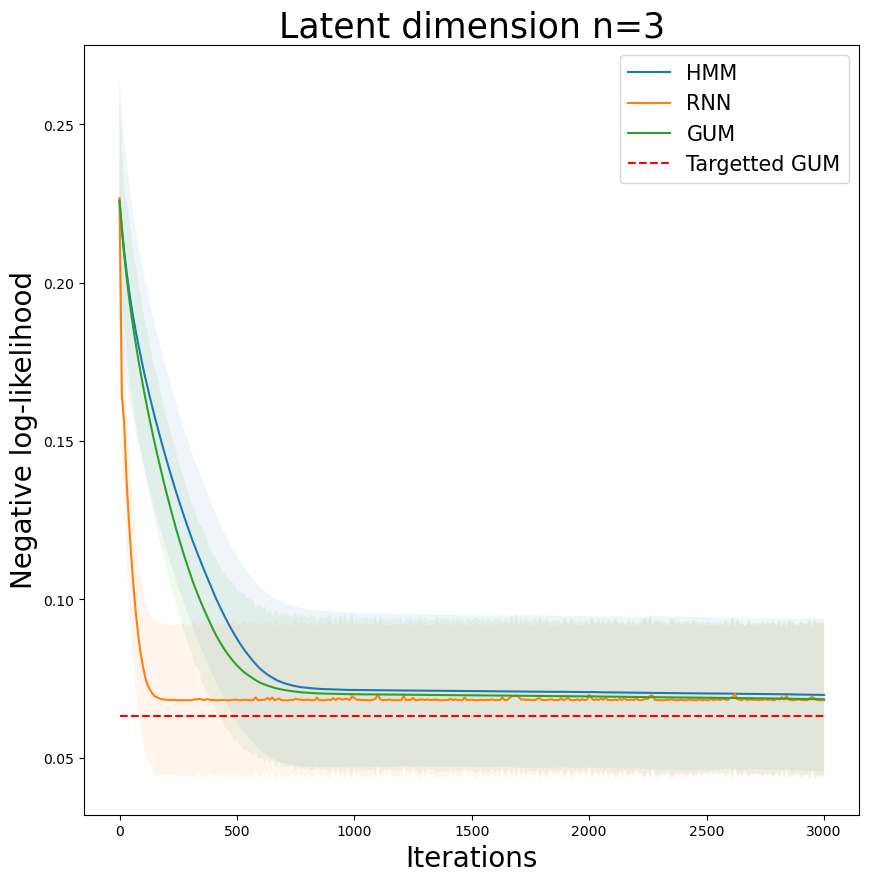

In [59]:
i = -1

means_hmm_ = means_hmm[:i]
stds_hmm_t = [m+s for m,s in zip(means_hmm_, stds_hmm[:len(means_hmm_)])]
stds_hmm_d = [m-s for m,s in zip(means_hmm_, stds_hmm[:len(means_hmm_)])]

means_rnn_ = means_rnn[:i]
stds_rnn_t = [m+s for m,s in zip(means_rnn_, stds_rnn[:len(means_rnn_)])]
stds_rnn_d = [m-s for m,s in zip(means_rnn_, stds_rnn[:len(means_rnn_)])]

means_gum_ = means_gum[:i]
stds_gum_t = [m+s for m,s in zip(means_gum_, stds_rnn[:len(means_gum_)])]
stds_gum_d = [m-s for m,s in zip(means_gum_, stds_rnn[:len(means_gum_)])]

means_unknown_gum_ = [unknown_gum_mean for _ in range(max(len(means_hmm_),len(means_rnn_)))]
x          = [x_*size_batch for x_ in range(len(means_unknown_gum_))]

plt.figure(figsize=(10, 10))

plt.plot(x, means_hmm_, label="HMM")
plt.fill_between(x, stds_hmm_d, stds_hmm_t, alpha=0.07)

plt.plot(x, means_rnn_, label="RNN")
plt.fill_between(x, stds_rnn_d, stds_rnn_t, alpha=0.07)

plt.plot(x, means_gum_, label="GUM")
plt.fill_between(x, stds_gum_d, stds_gum_t, alpha=0.07)



plt.plot(x, means_unknown_gum_, "r--", label="Targetted GUM")
plt.legend(fontsize=15)

plt.xlabel("Iterations", fontsize=20)
plt.ylabel("Negative log-likelihood", fontsize=20)
plt.title("Latent dimension n={0}".format(n), fontsize=25)
plt.show()